In [1]:
import glob

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
print(tf.__version__)

from sklearn.model_selection import train_test_split

from src.classes import Boundary, TankProperties32x2, BallAnomaly
from src.performance_evaluation import (
    center_of_mass,
    compute_position_error,
    compute_volume_error,
    compute_voxel_error,
)
from src.util import voxel_ball, plot_voxel_c
import os
from src.betaVAE_model import vae_model
import pandas as pd
import seaborn as sns
from tensorflow.keras.optimizers import SGD, Adam
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

boundary = Boundary()

2025-01-21 09:57:00.626859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737453420.744302 3295498 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737453420.780792 3295498 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 09:57:01.024342: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0


W0000 00:00:1737453431.074955 3295498 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


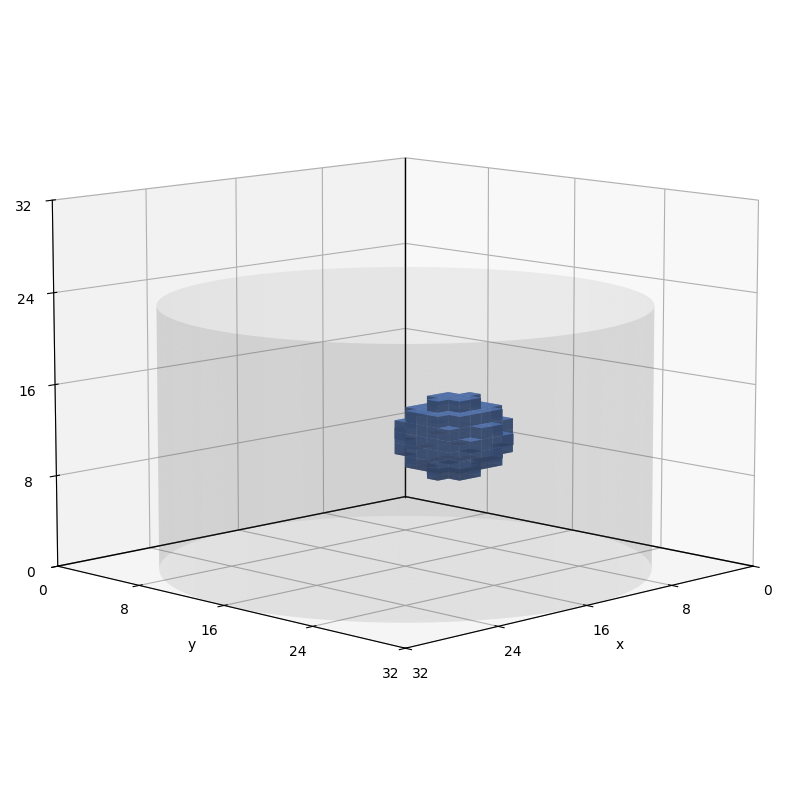

In [2]:
def voxel_ball(ball, boundary, empty_gnd=0, mask=False):
    
    scale_factor = 32 / 194  # 32 voxels / 194mm (tank diameter)
    ball_diameter_voxels = round(ball.d * scale_factor)
    #print(f"ball_diameter_voxels: {ball_diameter_voxels}")
    
    y, x, z = np.indices((boundary.x_length, boundary.y_length, boundary.z_length))
    voxel = (
        np.sqrt((x - ball.x) ** 2 + (y - ball.y) ** 2 + (z - ball.z) ** 2) < ball_diameter_voxels / 2
    )
    if mask:
        return voxel
    else:
        return np.where(voxel, ball.perm, empty_gnd)

def create_cylinder_mesh(radius, height, n_points=100):
    theta = np.linspace(0, 2*np.pi, n_points)
    z = np.linspace(0, height, n_points)
    theta, z = np.meshgrid(theta, z)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return x, y, z

def plot_tank_and_ball(ball: BallAnomaly, tank: TankProperties32x2, boundary: Boundary):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
   
    scale_factor = 32 / tank.T_d 
    
    cylinder_radius = tank.T_r * scale_factor
    cylinder_height = tank.T_bz[1] * scale_factor
    x_cyl, y_cyl, z_cyl = create_cylinder_mesh(cylinder_radius, cylinder_height)
    
    x_cyl += 16  
    y_cyl += 16  
    
    ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')
    
    ball_voxels = voxel_ball(ball, boundary)
    
    ax.voxels(ball_voxels.transpose(1, 0, 2), facecolors='cornflowerblue', alpha=0.8)
    
    ax.plot([0, boundary.x_length], [0, 0], [0, 0], 'k-', linewidth=1)
    #ax.text(boundary.x_length+1, 0, 0, 'x')
    
    ax.plot([0, 0], [0, boundary.y_length], [0, 0], 'k-', linewidth=1)
    #ax.text(0, boundary.y_length+1, 0, 'y')
    
    ax.plot([0, 0], [0, 0], [0, boundary.z_length], 'k-', linewidth=1)
    #ax.text(0, 0, boundary.z_length+1, 'z')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.set_xlim([boundary.x_0, boundary.x_length])
    ax.set_ylim([boundary.y_0, boundary.y_length])
    ax.set_zlim([boundary.z_0, boundary.z_length])

    ax.grid(True)
    
    ax.set_xticks([0, 8, 16, 24, 32])
    ax.set_yticks([0, 8, 16, 24, 32])
    ax.set_zticks([0, 8, 16, 24, 32])
    
    ax.view_init(elev=10, azim=45)
    
    plt.tight_layout()
    plt.show()

tank = TankProperties32x2()
ball = BallAnomaly(x=10.5, y=15, z=10, d=40, perm=1)
boundary = Boundary()

plot_tank_and_ball(ball, tank, boundary)

In [3]:
ball = BallAnomaly(x=10.5, y=10, z=10, d=38, perm=1)

In [4]:
ball_vxl = voxel_ball(ball, boundary)

In [5]:
#plot_voxel(ball_vxl)

In [6]:
gamma = list()
diameter_labels = list()
pos_ball = list()
vol_ball = list()
perm = 1
d = 40
scale_factor = 32 / 194  # Umrechnungsfaktor von mm in Voxel

d_voxels = round(d * scale_factor)

for x in np.linspace(boundary.x_0 + d_voxels//2, boundary.x_length - d_voxels//2, 32):
    for y in np.linspace(boundary.y_0 + d_voxels//2, boundary.y_length - d_voxels//2 , 32):
        for z in np.linspace(
            boundary.z_0 + d_voxels//2, boundary.z_length - d_voxels//2, 32
        ):
            ball = BallAnomaly(x, y, z, d, perm) 
            vxl_ball = voxel_ball(ball, boundary)
            gamma.append(vxl_ball)
            diameter_labels.append(d)  
            pos_ball.append([ball.y, ball.x, ball.z])
            vol_ball.append(np.where(vxl_ball == 1)[0].shape[0])

gamma = np.array(gamma) / 2
diameter_labels = np.array(diameter_labels)
pos_ball = np.array(pos_ball)
vol_ball = np.array(vol_ball)

In [7]:
gamma.shape

(32768, 32, 32, 32)

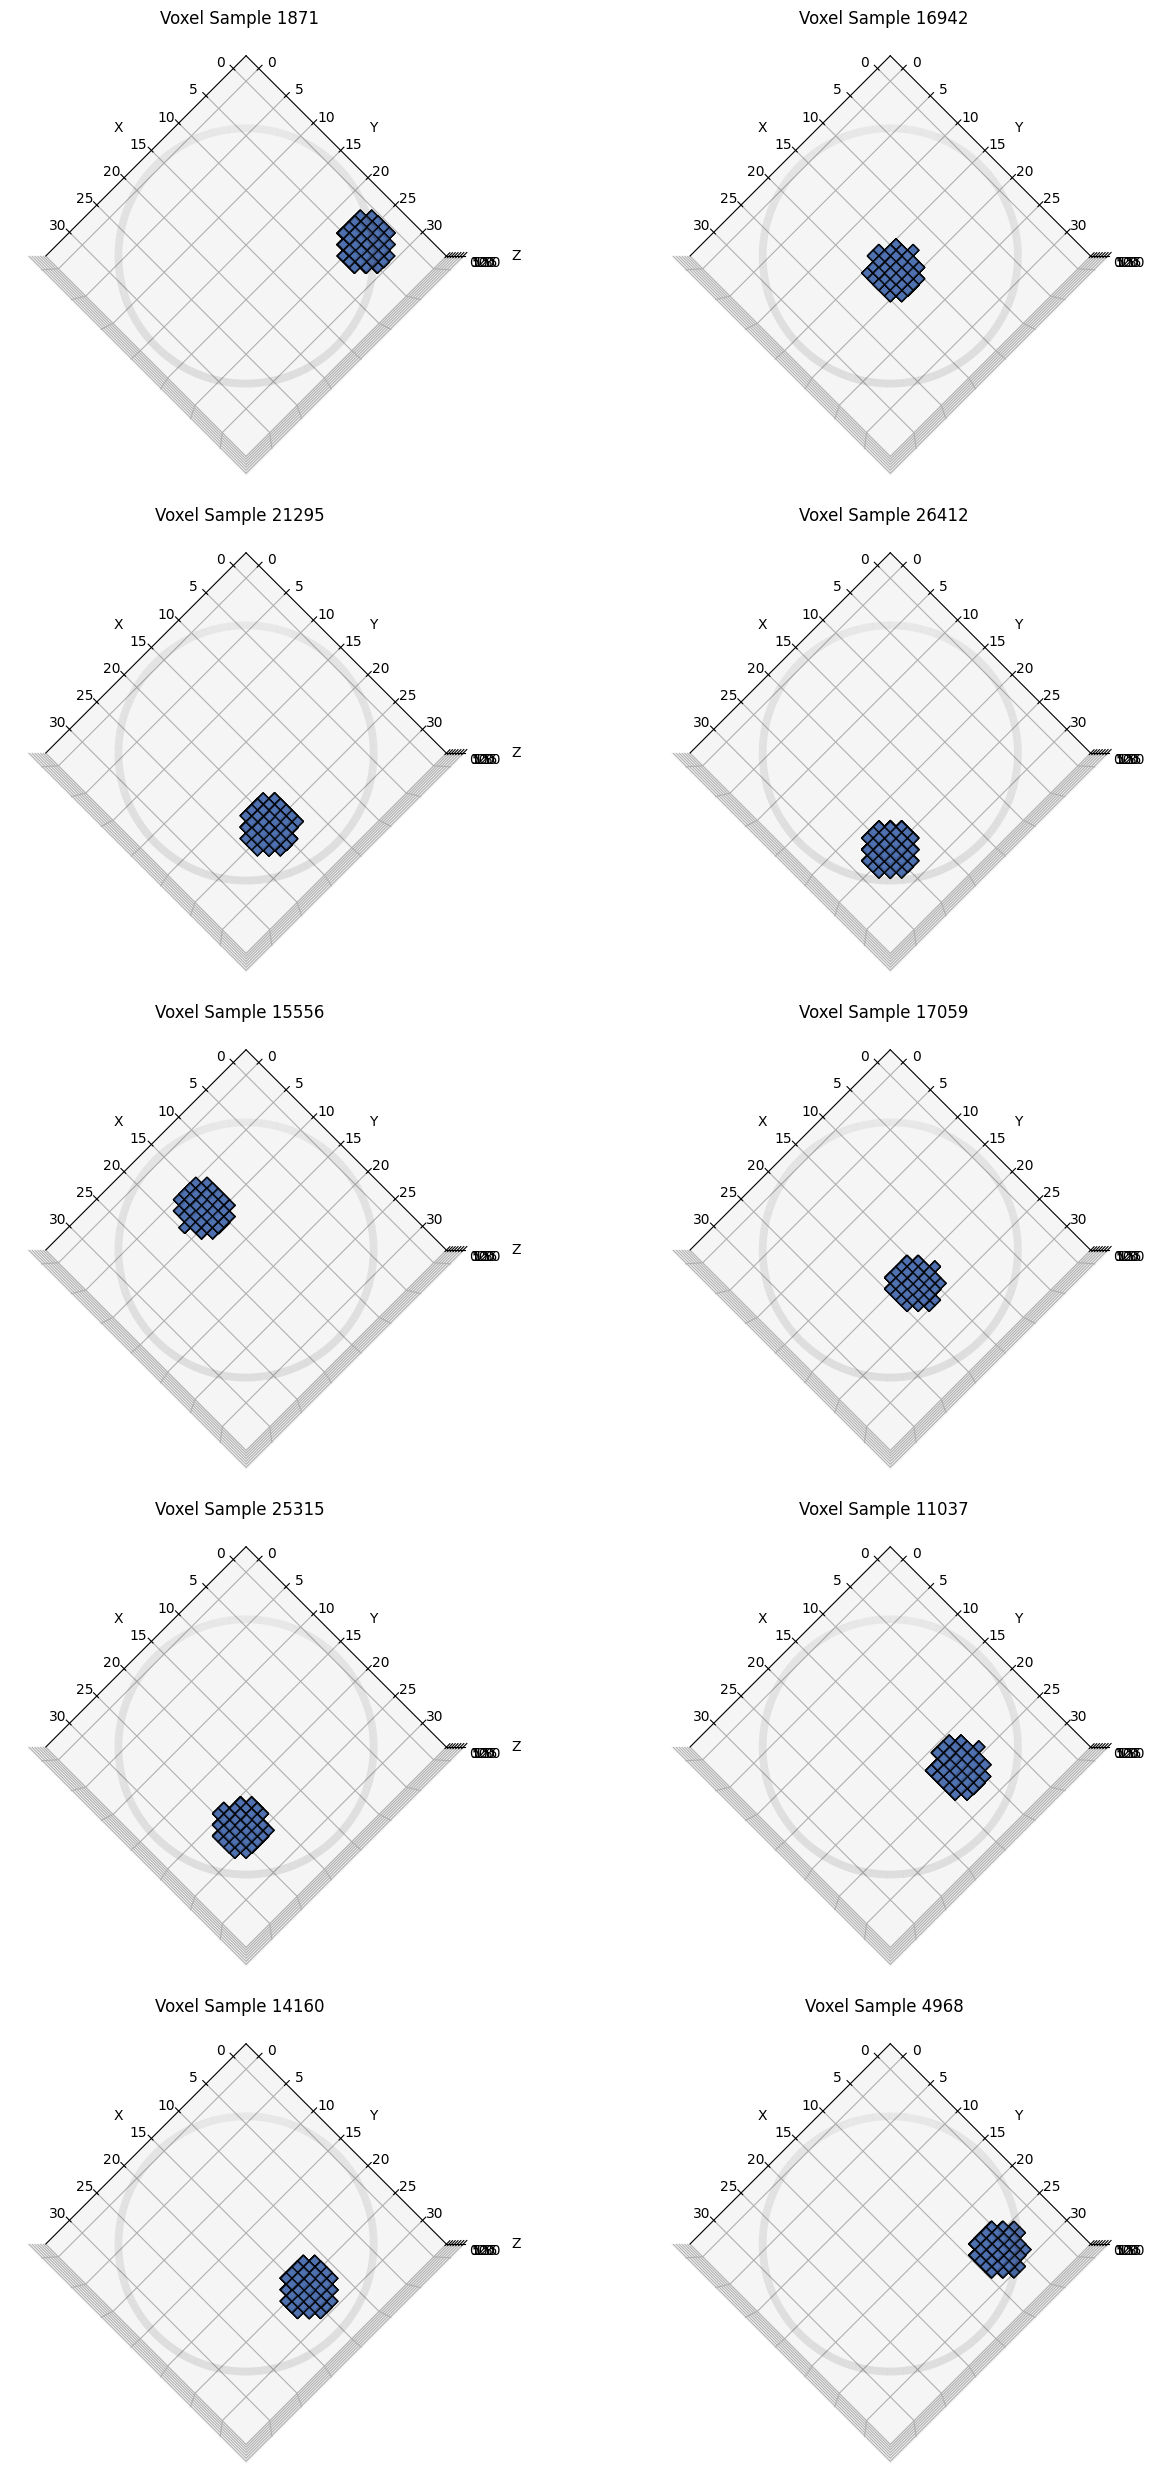

In [8]:
def plot_multiple_voxels(gamma, n_samples=10, figsize=(15, 25), color='cornflowerblue', alpha=0.8):

    random_indices = np.random.choice(len(gamma), size=n_samples, replace=False)

    fig = plt.figure(figsize=figsize)
    
    for i, idx in enumerate(random_indices):
        ax = fig.add_subplot(5, 2, i+1, projection='3d')
        cylinder_radius = tank.T_r * scale_factor
        cylinder_height = tank.T_bz[1] * scale_factor
        x_cyl, y_cyl, z_cyl = create_cylinder_mesh(cylinder_radius, cylinder_height)
    
        x_cyl += 16  
        y_cyl += 16  
    
        ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')
        
        ax.voxels(gamma[idx].transpose(1, 0, 2),
                 facecolors=color,
                 alpha=alpha,
                 edgecolor='k')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        ax.set_title(f'Voxel Sample {idx}')
    
        ax.view_init(elev=90, azim=45)

    plt.tight_layout()
    return fig

fig = plot_multiple_voxels(gamma)

In [9]:
(
    gamma_train,
    gamma_test,
    r_train,
    r_test,
    pos_train,
    pos_test,
    vol_train,
    vol_test,
) = train_test_split(
    gamma,
    diameter_labels,
    pos_ball,
    vol_ball,
    train_size=0.9,
    shuffle=True,
    random_state=42,
)

In [10]:
print(
    gamma_train.shape,
    gamma_test.shape,
    r_train.shape,
    r_test.shape,
    pos_train.shape,
    pos_test.shape,
    vol_train.shape,
    vol_test.shape,
)

(29491, 32, 32, 32) (3277, 32, 32, 32) (29491,) (3277,) (29491, 3) (3277, 3) (29491,) (3277,)


In [11]:
#for rdn in np.random.randint(low=0, high=X_train.shape[0], size=5):
    #print(rdn)
    #print("Pos:\t", pos_train[rdn])
    #print("Vol:\t", vol_train[rdn])
    #plot_voxel_c(X_train[rdn, ...] * 2)

In [12]:
#decoder = Model(decoder_inputs, decoder_outputs, name="VAE_decoder")
vae = vae_model()
input_shape=(32, 32, 32, 1)  # Form der Eingabedaten ohne Batch-Dimension
vae.build(input_shape=(None, *input_shape))
print(f"Modell gebaut: {vae.built}")
vae.encoder.summary()
vae.decoder.summary()

Modell gebaut: True


Model: "VAE_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │          4 │ input_layer_2[0]… │
│ (BatchNormalizatio… │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │        126 │ batch_normalizat… │
│                     │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │          4 │ conv3d_4[0][0]    │
│ (BatchNormalizatio… │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 16, 16,    │        252 │ batch_normalizat… │
│                     │ 16, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │          8 │ conv3d_5[0][0]    │
│ (BatchNormalizatio… │ 16, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 8, 8, 8,   │      1,004 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 8,   │         16 │ conv3d_6[0][0]    │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 4, 4, 4,   │      4,008 │ batch_normalizat… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 4,   │         32 │ conv3d_7[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      4,104 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      4,104 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,662 (53.37 KB)

 Trainable params: 13,630 (53.24 KB)

 Non-trainable params: 32 (128.00 B)

Model: "VAE_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 4, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_4              │ (None, 8, 8, 8, 8)     │         8,008 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 8, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_5              │ (None, 16, 16, 16, 4)  │         4,004 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 16, 4)  │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_6              │ (None, 32, 32, 32, 2)  │         1,002 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 32, 2)  │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_7              │ (None, 32, 32, 32, 1)  │           251 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 32, 1)  │             4 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,933 (70.05 KB)

 Trainable params: 17,903 (69.93 KB)

 Non-trainable params: 30 (120.00 B)

In [13]:
epochs = 50
batch_size = 32
beta = 1.04

#cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=0, start_from_epoch=47)

vae = vae_model(input_shape=(32, 32, 32, 1), filters=[1, 4, 8, 16], beta=beta)
vae.compile(optimizer=Adam())  # learning_rate = learning_rate



In [ ]:
history = vae.fit(
    np.expand_dims(gamma_train, 4),
    epochs=epochs,
    batch_size=batch_size,
    #callbacks=[cb],
)

Epoch 1/50
922/922 ━━━━━━━━━━━━━━━━━━━━ 501s 538ms/step - kl_loss: 7.5112 - loss: 656.5633 - reconstruction_loss: 648.7515 - total_loss: 656.5633
Epoch 2/50
922/922 ━━━━━━━━━━━━━━━━━━━━ 558s 606ms/step - kl_loss: 0.1394 - loss: 1431.0205 - reconstruction_loss: 1430.8755 - total_loss: 1431.0205
Epoch 3/50
922/922 ━━━━━━━━━━━━━━━━━━━━ 512s 555ms/step - kl_loss: 11.0951 - loss: 570.8951 - reconstruction_loss: 559.3562 - total_loss: 570.8951
Epoch 4/50
922/922 ━━━━━━━━━━━━━━━━━━━━ 532s 577ms/step - kl_loss: 3.9485 - loss: 597.5359 - reconstruction_loss: 593.4297 - total_loss: 597.5359
Epoch 5/50
922/922 ━━━━━━━━━━━━━━━━━━━━ 625s 678ms/step - kl_loss: 32.9977 - loss: 434.8802 - reconstruction_loss: 400.5628 - total_loss: 434.8802
Epoch 6/50
922/922 ━━━━━━━━━━━━━━━━━━━━ 617s 669ms/step - kl_loss: 28.7117 - loss: 353.3936 - reconstruction_loss: 323.5334 - total_loss: 353.3936
Epoch 7/50
922/922 ━━━━━━━━━━━━━━━━━━━━ 493s 534ms/step - kl_loss: 36.2746 - loss: 391.9473 - reconstruction_loss: 354

In [ ]:
fpath = 'Abbildungen/'  
fname = 'loss_curve_3Dvae'

plt.figure(figsize=(8, 6))
plt.plot(history.history["reconstruction_loss"], label="Training Loss")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()

plt.savefig(f'{fpath}{fname}.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
vae = vae_model()  
vae.build(input_shape=(32, 32, 32, 1)) 
vae_idx = len(glob.glob("weights/3Dvae*.h5")) + 1
vae.save_weights(f"weights/3Dvae_{vae_idx}.weights.h5")

In [ ]:
vae = vae_model()  
vae.build(input_shape=(32, 32, 32, 1)) 
vae.load_weights("weights/vae_4.weights.h5")
print("Gewichte erfolgreich geladen.")

In [ ]:
from src.util import plot_voxel_c

In [ ]:
plt.style.use("default")
for rdn in np.random.randint(low=0, high=gamma_test.shape[0], size=5):
    print("Original...")
    plot_voxel_c(gamma_test[rdn, ...])

    print("Prediction...")
    _, _, z = vae.encoder.predict(np.expand_dims(gamma_test[rdn, ...], 0))
    sgl_pred = vae.decoder.predict(z)
    sgl_pred = np.squeeze(sgl_pred, axis=4)
    sgl_pred = np.squeeze(sgl_pred, axis=0)
    sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)
    plot_voxel_c(sgl_pred)

In [ ]:
sgl_pred.shape